#LightGBM Model

Trying a LightGBM model based on some of the discussions on kaggle around how to work with the large amount of data provided. LightGBM is a unique in that the model builds trees horizontally as opposed to other algorithms that grow trees vertically. Upon further reading of the documentation we have found the biggest advantages to using this approach are as follows: 


*   Can handle large data sets in less time than many other models
*   LightGBM models can use categorical features as an input directly without the need for one-hot encoding. It is about 8 times faster than one-hot encoding 
*   Less Memory Usage
*   Because of the complexity of trees created by leaf-wise split LightGBM Models have a better accuracy as compared to other boosted models 

Disadvantages of using a LightGBM model are as follows: 
*   Can easily overfit
*   Not ideal for small datasets




######*Sources:* 

*   https://lightgbm.readthedocs.io/en/latest/pythonapi/lightgbm.LGBMClassifier.html
*   https://lightgbm.readthedocs.io/en/latest/Python-Intro.html
*   https://www.kaggle.com/general/264327
*   https://www.analyticsvidhya.com/blog/2021/08/complete-guide-on-how-to-use-lightgbm-in-python/


##Import Libraries & Data

We did find a useful library (fast_ml) that creates a test, train and validation set all in one line of code. While we did use it for our first approach when training our simple LGBM model we did not end up using it for the second attempt at trianing our model using cross validation. Further information about the library can be found [here](#https://www.kaggle.com/code/nextbigwhat/train-valid-test-split-instead-of-train-test-split/notebook). 

In [1]:
#install new library for split of train, test and validation
!pip install fast_ml --upgrade

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.1/42.1 kB 2.2 MB/s eta 0:00:00


In [2]:
#Library import for LGBM
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report, confusion_matrix
from sklearn.model_selection import KFold, train_test_split, cross_val_score
from fast_ml.model_development import train_valid_test_split
import lightgbm as lgb
import seaborn as sns

### Importing Data - Version 3
Feature engineering of data version 3. 

In [3]:
#Based on the documentation found for LGBMClassifer parameters, 
#Setting data types as catagory for auto detection by LGBM.
dtypes = {
    'ip': 'category',
    'app': 'category',
    'device': 'category',
    'os': 'category',
    'channel': 'category',
    'click_time': 'str',
    'attributed_time': 'str',
    'is_attributed': 'category', 
    'hour' : 'category',
    'day' : 'category'
}

#Read in the new data with additional feature engineering. 
#We have done this so it is faster than running the entire notebook 
#to generate the data set
df3 = pd.read_csv('train_v3_neat.csv', dtype=dtypes, )
df3.head()


,ip,app,device,os,channel,click_time,attributed_time,is_attributed,hour,day,device_by_ip_day_hour,device_by_ip_app,device_by_ip_app_os,mean_of_hour_given_ip_app_device,next_click_for_ip_app_device_os,next_click_for_unique_comb_ip_app_channel_os,next_click_for_unique_comb_ip_device_channel_os
0,103175,18,1,17,376,2017-11-06 14:53:23,NaN,0,14,6,1,216,8,8.287879,27790,49120,226388
1,204158,35,1,13,21,2017-11-06 15:41:07,2017-11-07 08:17:19,1,15,6,1,1,1,15.000000,1490017133,47237,1490017133
2,11901,64,1,22,459,2017-11-06 15:45:05,NaN,0,15,6,1,17,2,10.941176,53273,53273,53273
3,23892,3,1,19,379,2017-11-06 15:50:54,NaN,0,15,6,1,275,72,7.127273,33142,46676,46539
4,79213,14,1,19,478,2017-11-06 15:57:36,NaN,0,15,6,1,269,53,11.134387,271,1490016144,31749


In [4]:
#drop all unusded cols from the dataframe
df3 = df3.drop(['click_time', 'attributed_time'], axis=1)
df3.head()

,ip,app,device,os,channel,is_attributed,hour,day,device_by_ip_day_hour,device_by_ip_app,device_by_ip_app_os,mean_of_hour_given_ip_app_device,next_click_for_ip_app_device_os,next_click_for_unique_comb_ip_app_channel_os,next_click_for_unique_comb_ip_device_channel_os
0,103175,18,1,17,376,0,14,6,1,216,8,8.287879,27790,49120,226388
1,204158,35,1,13,21,1,15,6,1,1,1,15.000000,1490017133,47237,1490017133
2,11901,64,1,22,459,0,15,6,1,17,2,10.941176,53273,53273,53273
3,23892,3,1,19,379,0,15,6,1,275,72,7.127273,33142,46676,46539
4,79213,14,1,19,478,0,15,6,1,269,53,11.134387,271,1490016144,31749


In [5]:
print(df3.shape)

#Removing any NAN values to avoid error flag from LBGMClassifer when using cross validation
df3.dropna(inplace=True)
df3.count()

(956846, 15)


ip                                                 956846
app                                                956846
device                                             956846
os                                                 956846
channel                                            956846
is_attributed                                      956846
hour                                               956846
day                                                956846
device_by_ip_day_hour                              956846
device_by_ip_app                                   956846
device_by_ip_app_os                                956846
mean_of_hour_given_ip_app_device                   956846
next_click_for_ip_app_device_os                    956846
next_click_for_unique_comb_ip_app_channel_os       956846
next_click_for_unique_comb_ip_device_channel_os    956846
dtype: int64

## Basic LightGBM Model



In [6]:
#Using fast_ml library to create a train, validation and test set
x_train_b, y_train_b, x_valid_b, y_valid_b, x_test_b, y_test_b = train_valid_test_split(df3, 
                                                                            target = 'is_attributed', 
                                                                            train_size=0.8, 
                                                                            valid_size=0.1, 
                                                                            test_size=0.1)

print(x_train_b.shape), print(y_train_b.shape)
print(x_valid_b.shape), print(y_valid_b.shape)
print(x_test_b.shape), print(y_test_b.shape)

(765476, 14)
(765476,)
(95685, 14)
(95685,)
(95685, 14)
(95685,)


(None, None)

#### Default Model Parameters Using Training Set Version 3

In [24]:
#Building a very simple LGM Model
#default settings are as follows for LGBMClassifier
               #(boosting_type='gbdt', num_leaves=31, max_depth=-1, learning_rate=0.1, 
               #n_estimators=100, subsample_for_bin=200000, objective=None, class_weight=None, 
               #min_split_gain=0.0, min_child_weight=0.001, min_child_samples=20, subsample=1.0, 
               #subsample_freq=0, colsample_bytree=1.0, reg_alpha=0.0, reg_lambda=0.0, 
               #random_state=None, n_jobs=None, importance_type='split', **kwargs)
lgb_model = lgb.LGBMClassifier()
#Adjusted subsample_for_bin=200000 to 100000 with no change in model accuracy (valid 93.93% & train_test 93.90%)
#Adjusted learning_rate=0.1 to 0.01 with a decrease in model accuracy (valid 93.42% & train_test 93.28%)
#Adjusted learning_rate=0.1 to 0.05 with a decrease in model accuracy (valid 93.83% & train_test 93.78%)
#Adjusted boosting_rate='gbdt' to 'dart' with a decrease in model accuracy (valid 93.82% & train_test 93.75%)
#Adjusted min_child_samples=20 to 50 with a decrease in model accuracy (valid 93.94% & train_test 93.90%)

lgb_model.fit(x_train_b, y_train_b)
#default parameters for .fit: (X, y, sample_weight=None, init_score=None, eval_set=None, eval_names=None, 
                              #eval_sample_weight=None, eval_class_weight=None, eval_init_score=None, 
                              #eval_metric=None, feature_name='auto', categorical_feature='auto', 
                              #callbacks=None, init_model=None)
#No need to set catagorical features as the default is 'auto' 
#additional sources that were used to evaluate this are as follows: 
              #https://www.kaggle.com/getting-started/203471  
              #https://lightgbm.readthedocs.io/en/latest/pythonapi/lightgbm.LGBMClassifier.html

LGBMClassifier()

In [25]:
#predicting the labes on x_valid
y_valid_pred_b = lgb_model.predict(x_valid_b)

#Checking the accuracy of our model based on our predictions: Valid Set
print('LightGBM Model accuracy score: {0:0.4f}'.format(accuracy_score(y_valid_b, y_valid_pred_b)))

#looking at the accuracy of our training set
y_pred_train_b = lgb_model.predict(x_train_b)
print('Training-set accuracy score: {0:0.4f}'. format(accuracy_score(y_train_b, y_pred_train_b)))

LightGBM Model accuracy score: 0.9393
Training-set accuracy score: 0.9437


In [26]:
#Checking for overfitting
#They are close and do not suspect any overfitting occuring. 
print('Training set score: {:.4f}'.format(lgb_model.score(x_train_b, y_train_b)))
print('Validation set score: {:.4f}'.format(lgb_model.score(x_valid_b, y_valid_b)))

Training set score: 0.9437
Validation set score: 0.9393


Confusion Matrix
 [[48298  1892]
 [ 3917 41578]]


<Axes: >

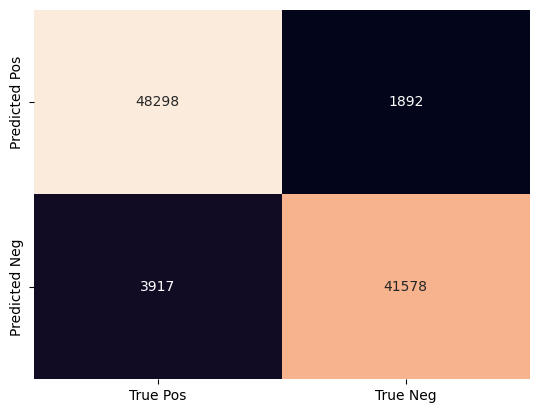

In [27]:
#Confusion Matrix of the validation set
conf_matrix = confusion_matrix(y_valid_b, y_valid_pred_b)
print('Confusion Matrix\n', conf_matrix)

#Heatmap
conf_matrix_hm = pd.DataFrame(data=conf_matrix, columns=['True Pos', 'True Neg'], index=['Predicted Pos', 'Predicted Neg'])
sns.heatmap(conf_matrix_hm, annot=True, fmt='d', cbar=False)

In [28]:
print(classification_report(y_valid_b, y_valid_pred_b))

              precision    recall  f1-score   support

           0       0.92      0.96      0.94     50190
           1       0.96      0.91      0.93     45495

    accuracy                           0.94     95685
   macro avg       0.94      0.94      0.94     95685
weighted avg       0.94      0.94      0.94     95685



In [29]:
#predicting the labes on x_test created from the training set
y_test_pred_b = lgb_model.predict(x_test_b)

#Checking the accuracy of our model based on our predictions: test Set
print('LightGBM Model accuracy score: {0:0.4f}'.format(accuracy_score(y_test_b, y_test_pred_b)))

LightGBM Model accuracy score: 0.9390


## LightGBM Model with Cross Validation 

In [30]:
#Selecting features and setting label

#Limited features produced a Mean AUC = 0.9803 and a Mean Val Acc = 0.9351
#features = df3[['ip', 'app', 'device', 'os', 'channel', 'hour', 'day', 'next_click_for_ip_app_device_os', 'next_click_for_unique_comb_ip_app_channel_os', 'next_click_for_unique_comb_ip_device_channel_os']]

#Trying with all cols
features = df3[['ip', 'app', 'device', 'os', 'channel', 'hour', 'day', 
                'device_by_ip_day_hour', 'device_by_ip_app', 'device_by_ip_app_os', 
                'mean_of_hour_given_ip_app_device', 'next_click_for_ip_app_device_os', 
                'next_click_for_unique_comb_ip_app_channel_os', 'next_click_for_unique_comb_ip_device_channel_os']]
labels = df3['is_attributed']
print(features.shape)
print(labels.shape)

x_train, x_test, y_train, y_test = train_test_split(features, labels, test_size=0.01, random_state=42)
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

(956846, 14)
(956846,)
(947277, 14) (947277,)
(9569, 14) (9569,)


In [31]:
## Function fitting model using CV
def cv_model(model, x_train, y_train):
    """
    Function for fitting a model using cross-validation

    Input parameters:
    model: model to train
    x_test: train features
    y_test: train labels

    Output variables:
    model: trained model
    accuracies: list of accuracies for each iteration
    oof_auc = average auc score
    """

    # tracking variables
    fold = 0 
    auc_accuracies = []
    val_accuracies = []

    # creating CV generator
    kf = KFold(n_splits=5, shuffle=True, random_state=42)

    for train_idx, val_idx in kf.split(x_train, y_train):
        # creating train/val set
        x_tr = x_train.iloc[train_idx]
        y_tr = y_train.iloc[train_idx]

        x_val = x_train.iloc[val_idx]
        y_val = y_train.iloc[val_idx]

        # Fit Model
        model.fit(x_tr, y_tr)
        pred = model.predict(x_val)
        pred_prob = model.predict_proba(x_val)[:,1]
        val_acc_score = accuracy_score(y_val, pred)
        auc_score = roc_auc_score(y_val, pred_prob)
        print(f"======= Fold {fold} ========")
        print(
            f"Our accuracy on the validation set is {val_acc_score:0.4f} and AUC is {auc_score:0.4f}"
        )
        fold += 1
        auc_accuracies.append(auc_score)
        val_accuracies.append(val_acc_score)

    oof_auc = np.mean(auc_accuracies)
    mean_val_acc = np.mean(val_accuracies)
    print(f"======= Mean AUC ========\n{oof_auc:.4f}")
    print(f"======= Mean Val Acc ========\n{mean_val_acc:.4f}")
    return auc_accuracies, val_accuracies

In [34]:
lgb_model = lgb.LGBMClassifier()

In [35]:
lgb_model = lgb.LGBMClassifier(num_leaves=62)
lgb_val_acc, lgb_oof_auc = cv_model(lgb_model, x_train, y_train)

======= Fold 0 ========
Our accuracy on the validation set is 0.9393 and AUC is 0.9832
======= Fold 1 ========
Our accuracy on the validation set is 0.9390 and AUC is 0.9829
======= Fold 2 ========
Our accuracy on the validation set is 0.9398 and AUC is 0.9831
======= Fold 3 ========
Our accuracy on the validation set is 0.9399 and AUC is 0.9832
======= Fold 4 ========
Our accuracy on the validation set is 0.9388 and AUC is 0.9829
======= Mean AUC ========
0.9831
======= Mean Val Acc ========
0.9393


In [ ]:
## Function for evaluating model

def eval_model(model, x_test, y_test):
    """
    Function for evaluating model's performance.
    
    Input parameters:
    model: model to evaluate
    x_test: test features
    y_test: test labels

    Output variables:
    acc_score: accuracy score
    auc_score: area under the curve score
    test_pred: test predictions
    test_pred_prob: test prediction probabilities
    """

    ## Evaluating model on test data
    test_pred = model.predict(x_test)
    test_pred_prob = model.predict_proba(x_test)[:,1]
    acc_score = accuracy_score(y_test, test_pred)
    auc_score = roc_auc_score(y_test, test_pred_prob)
    print(f"Accuracy Score: {acc_score:.4f}\nAUC Score: {auc_score:.4f}")

    return acc_score, auc_score, test_pred, test_pred_prob

In [ ]:
lgb_trained = lgb_model.fit(x_train, y_train)
lgb_acc_score, lgb_auc_score, lgb_test_pred, lgb_test_pred_prob = eval_model(lgb_trained, x_test, y_test)

Accuracy Score: 0.9404
AUC Score: 0.9833


In [ ]:
#Loading in another dataset with additional feature engineering done. 

#Based on the documentation found for LGBMClassifer parameters, 
#Setting data types as catagory for auto detection by LGBM.
dtypes = {
    'ip': 'category',
    'app': 'category',
    'device': 'category',
    'os': 'category',
    'channel': 'category',
    'click_time': 'str',
    'attributed_time': 'str',
    'is_attributed': 'category', 
    'hour' : 'category',
    'day' : 'category'
}

#Read in the new data with additional feature engineering. 
#We have done this so it is faster than running the entire notebook 
#to generate the data set
final_train = pd.read_csv('final_train.csv', dtype=dtypes, )
final_train.head()


,ip,app,device,os,channel,click_time,attributed_time,is_attributed,hour,day,...,var_of_hour_given_ip_device_day,var_of_hour_given_ip_os_app,var_of_day_given_ip_app_device,mean_of_hour_given_ip_app_device,next_click_for_ip_app_device_os,next_click_for_unique_comb_ip_app_channel_os,next_click_for_unique_comb_ip_device_channel_os,channel_by_ip_app,channel_by_ip_day_hour,channel_by_ip_app_os
0,103175,18,1,17,376,2017-11-06 14:53:23,NaN,0,14,6,...,6.223268,48.125000,1.162488,8.287879,27790,-16416,29780,216,1,8
1,204158,35,1,13,21,2017-11-06 15:41:07,2017-11-07 08:17:19,1,15,6,...,7.563406,NaN,NaN,15.000000,1490017133,-18299,-9363,1,1,1
2,11901,64,1,22,459,2017-11-06 15:45:05,NaN,0,15,6,...,13.437908,40.500000,0.529412,10.941176,53273,-12263,-12263,17,1,2
3,23892,3,1,19,379,2017-11-06 15:50:54,NaN,0,15,6,...,5.491180,20.140844,0.637611,7.127273,33142,-18860,-18997,275,1,72
4,79213,14,1,19,478,2017-11-06 15:57:36,NaN,0,15,6,...,7.253513,25.688679,1.291957,11.134387,271,-10352,31749,269,1,53


In [ ]:
#drop all unusded cols from the dataframe
final_train = final_train.drop(['click_time', 'attributed_time'], axis=1)
final_train.head()

,ip,app,device,os,channel,is_attributed,hour,day,device_by_ip_day_hour,device_by_ip_app,...,var_of_hour_given_ip_device_day,var_of_hour_given_ip_os_app,var_of_day_given_ip_app_device,mean_of_hour_given_ip_app_device,next_click_for_ip_app_device_os,next_click_for_unique_comb_ip_app_channel_os,next_click_for_unique_comb_ip_device_channel_os,channel_by_ip_app,channel_by_ip_day_hour,channel_by_ip_app_os
0,103175,18,1,17,376,0,14,6,1,216,...,6.223268,48.125000,1.162488,8.287879,27790,-16416,29780,216,1,8
1,204158,35,1,13,21,1,15,6,1,1,...,7.563406,NaN,NaN,15.000000,1490017133,-18299,-9363,1,1,1
2,11901,64,1,22,459,0,15,6,1,17,...,13.437908,40.500000,0.529412,10.941176,53273,-12263,-12263,17,1,2
3,23892,3,1,19,379,0,15,6,1,275,...,5.491180,20.140844,0.637611,7.127273,33142,-18860,-18997,275,1,72
4,79213,14,1,19,478,0,15,6,1,269,...,7.253513,25.688679,1.291957,11.134387,271,-10352,31749,269,1,53


In [ ]:
print(final_train.shape)

#Removing any NAN values to avoid error flag from LBGMClassifer when using cross validation
#final_train.dropna(inplace=True)
#final_train.count()

(956846, 21)


ip                                                 689216
app                                                689216
device                                             689216
os                                                 689216
channel                                            689216
is_attributed                                      689216
hour                                               689216
day                                                689216
device_by_ip_day_hour                              689216
device_by_ip_app                                   689216
device_by_ip_app_os                                689216
var_of_hour_given_ip_device_day                    689216
var_of_hour_given_ip_os_app                        689216
var_of_day_given_ip_app_device                     689216
mean_of_hour_given_ip_app_device                   689216
next_click_for_ip_app_device_os                    689216
next_click_for_unique_comb_ip_app_channel_os       689216
next_click_for

In [ ]:
x_train_ft, y_train_ft, x_valid_ft, y_valid_ft, x_test_ft, y_test_ft = train_valid_test_split(final_train, 
                                                                            target = 'is_attributed', 
                                                                            train_size=0.8, 
                                                                            valid_size=0.1, 
                                                                            test_size=0.1)

print(x_train_ft.shape), print(y_train_ft.shape)
print(x_valid_ft.shape), print(y_valid_ft.shape)
print(x_test_ft.shape), print(y_test_ft.shape)

(765476, 20)
(765476,)
(95685, 20)
(95685,)
(95685, 20)
(95685,)


(None, None)

In [ ]:
lgb_model = lgb.LGBMClassifier(boosting_type='dart')
#boosting_type=dart resulted in a 93.88% accuracy on the validation set. 
lgb_model.fit(x_train_ft, y_train_ft)

LGBMClassifier(boosting_type='dart')

In [ ]:
#predicting the labes on x_valid
y_valid_pred_ft = lgb_model.predict(x_valid_ft)

#Checking the accuracy of our model based on our predictions: Valid Set
print('LightGBM Model accuracy score: {0:0.4f}'.format(accuracy_score(y_valid_ft, y_valid_pred_ft)))

LightGBM Model accuracy score: 0.9388


In [ ]:
#Selecting features and setting label

#Limited features produced a Mean AUC = 0.9803 and a Mean Val Acc = 0.9351
#features = df3[['ip', 'app', 'device', 'os', 'channel', 'hour', 'day', 'next_click_for_ip_app_device_os', 'next_click_for_unique_comb_ip_app_channel_os', 'next_click_for_unique_comb_ip_device_channel_os']]

#Trying with all cols
features = final_train[['ip', 'app', 'device', 'os', 'channel', 'hour', 'day', 
                'device_by_ip_day_hour', 'device_by_ip_app', 'device_by_ip_app_os', 
                'mean_of_hour_given_ip_app_device', 'next_click_for_ip_app_device_os', 
                'next_click_for_unique_comb_ip_app_channel_os', 'next_click_for_unique_comb_ip_device_channel_os']]
labels = final_train['is_attributed']
print(features.shape)
print(labels.shape)

x_train_ft, x_test_ft, y_train_ft, y_test_ft = train_test_split(features, labels, test_size=0.01, random_state=42)
print(x_train_ft.shape, y_train_ft.shape)
print(x_test_ft.shape, y_test_ft.shape)

In [ ]:
lgb_val_acc, lgb_oof_auc = cv_model(lgb_model, x_train_ft, y_train_ft)